# **Installs and imports**

In [1]:
#Doing all the imports here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist, squareform
from scipy.stats import ttest_ind
import plotly.graph_objects as go

# **1D analysis**

In [2]:
#Load data
df = pd.read_csv('/content/stock_details_5_years.csv', parse_dates=['Date'])
df = df.sort_values(['Company', 'Date'])

#Compute daily returns and volatility per stock
df['return'] = df.groupby('Company')['Close'].pct_change()
volatility = df.groupby('Company')['return'].std().rename('volatility').dropna()

#Define groups: low vs high volatility quartiles
q_low, q_high = volatility.quantile([0.25, 0.75])
groups = pd.Series('mid', index=volatility.index)
groups[volatility <= q_low] = 'low_vol'
groups[volatility >= q_high] = 'high_vol'

#RQA helper functions
def embed(ts, m=1, tau=1):
    N = len(ts) - (m - 1) * tau
    return np.column_stack([ts[i * tau : i * tau + N] for i in range(m)])

def recurrence_plot(X, recurrence_rate=0.05):
    D = squareform(pdist(X, metric='euclidean'))
    thresh = np.percentile(D, recurrence_rate * 100)
    return (D <= thresh).astype(int)

def diagonal_line_stats(R, l_min=2):
    N = R.shape[0]
    diag_runs = []
    for k in range(-N+1, N):
        diag = np.diagonal(R, offset=k)
        lengths = np.diff(np.where(np.concatenate([[0], diag, [0]]) != 1)[0]) - 1
        diag_runs.extend(lengths[lengths >= l_min])
    if len(diag_runs) == 0 or R.sum() == 0:
        return 0.0, 0.0
    det = sum(diag_runs) / R.sum()
    mean_len = np.mean(diag_runs)
    return det, mean_len

#Compute DET and MDL for each stock
results = []
for sym, grp in groups.items():
    ts = df[df['Company'] == sym]['Close'].dropna().values
    if len(ts) < 50:
        continue
    ts = (ts - ts.mean()) / ts.std()
    X = embed(ts, m=1, tau=1)
    R = recurrence_plot(X, recurrence_rate=0.05)
    det, mdl = diagonal_line_stats(R, l_min=2)
    results.append({'Company': sym, 'group': grp, 'DET': det, 'MDL': mdl})

rqa_df = pd.DataFrame(results)

#Compare low vs high volatility
low = rqa_df[rqa_df['group'] == 'low_vol']
high = rqa_df[rqa_df['group'] == 'high_vol']
t_det, p_det = ttest_ind(low['DET'], high['DET'], equal_var=False)
t_mdl, p_mdl = ttest_ind(low['MDL'], high['MDL'], equal_var=False)

print(f"DET: t={t_det:.2f}, p={p_det:.3f}")
print(f"MDL: t={t_mdl:.2f}, p={p_mdl:.3f}")

if abs(t_det) > abs(t_mdl):
    print("DET differentiates the groups more strongly.")
else:
    print("MDL differentiates the groups more strongly.")


DET: t=-0.25, p=0.806
MDL: t=-2.21, p=0.028
MDL differentiates the groups more strongly.


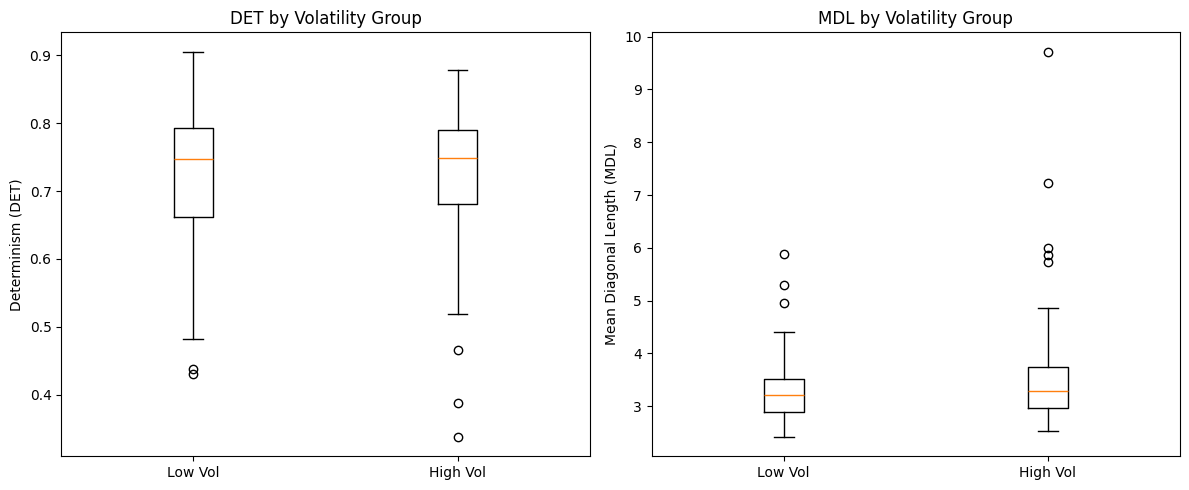

In [3]:
#Load data
df = pd.read_csv('/content/stock_details_5_years.csv', parse_dates=['Date'])
df = df.sort_values(['Company', 'Date'])
df['return'] = df.groupby('Company')['Close'].pct_change()

#Compute volatility & define groups
vol = df.groupby('Company')['return'].std().dropna()
q_low, q_high = vol.quantile([0.25, 0.75])
groups = pd.Series('mid', index=vol.index)
groups[vol <= q_low] = 'low_vol'
groups[vol >= q_high] = 'high_vol'

#RQA helper functions
def embed(ts, m=1, tau=1):
    N = len(ts) - (m - 1) * tau
    return np.column_stack([ts[i*tau : i*tau+N] for i in range(m)])

def recurrence_plot(X, recurrence_rate=0.05):
    D = squareform(pdist(X, 'euclidean'))
    thresh = np.percentile(D, recurrence_rate*100)
    return (D <= thresh).astype(int)

def diagonal_stats(R, l_min=2):
    N = R.shape[0]
    runs = []
    for k in range(-N+1, N):
        d = np.diagonal(R, offset=k)
        lengths = np.diff(np.where(np.concatenate([[0],d,[0]])!=1)[0]) - 1
        runs += list(lengths[lengths>=l_min])
    if not runs or R.sum()==0:
        return 0.0, 0.0
    det = sum(runs)/R.sum()
    return det, np.mean(runs)

#Compute DET & MDL for each stock
records = []
for sym, grp in groups.items():
    ts = df[df['Company']==sym]['Close'].dropna().values
    if len(ts)<50: continue
    ts = (ts - ts.mean())/ts.std()
    R = recurrence_plot(embed(ts, m=1, tau=1), recurrence_rate=0.05)
    det, mdl = diagonal_stats(R, l_min=2)
    records.append((sym, grp, det, mdl))

rqa_df = pd.DataFrame(records, columns=['Company','group','DET','MDL'])

#Plot boxplots
fig, axes = plt.subplots(1,2, figsize=(12,5), sharey=False)

#DET
axes[0].boxplot([
    rqa_df[rqa_df['group']=='low_vol']['DET'],
    rqa_df[rqa_df['group']=='high_vol']['DET']
])
axes[0].set_xticks([1,2])
axes[0].set_xticklabels(['Low Vol','High Vol'])
axes[0].set_ylabel('Determinism (DET)')
axes[0].set_title('DET by Volatility Group')

#MDL
axes[1].boxplot([
    rqa_df[rqa_df['group']=='low_vol']['MDL'],
    rqa_df[rqa_df['group']=='high_vol']['MDL']
])
axes[1].set_xticks([1,2])
axes[1].set_xticklabels(['Low Vol','High Vol'])
axes[1].set_ylabel('Mean Diagonal Length (MDL)')
axes[1].set_title('MDL by Volatility Group')

plt.tight_layout()
plt.show()


# **3D analysis**

In [4]:
#Load data
df = pd.read_csv('/content/stock_details_5_years.csv', parse_dates=['Date'])
df = df.sort_values(['Company', 'Date'])
df['return'] = df.groupby('Company')['Close'].pct_change()

#Compute volatility & define groups
vol = df.groupby('Company')['return'].std().dropna()
q_low, q_high = vol.quantile([0.25, 0.75])
groups = pd.Series('mid', index=vol.index)
groups[vol <= q_low] = 'low_vol'
groups[vol >= q_high] = 'high_vol'

#RQA helper functions
def embed(ts, m=3, tau=1):
    N = len(ts) - (m - 1) * tau
    return np.column_stack([ts[i * tau : i * tau + N] for i in range(m)])

def recurrence_plot(X, recurrence_rate=0.05):
    D = squareform(pdist(X, 'euclidean'))
    thresh = np.percentile(D, recurrence_rate * 100)
    return (D <= thresh).astype(int)

def diagonal_stats(R, l_min=2):
    N = R.shape[0]
    runs = []
    for k in range(-N + 1, N):
        d = np.diagonal(R, offset=k)
        lengths = np.diff(np.where(np.concatenate([[0], d, [0]]) != 1)[0]) - 1
        runs.extend(lengths[lengths >= l_min])
    if not runs or R.sum() == 0:
        return 0.0, 0.0
    det = sum(runs) / R.sum()
    return det, np.mean(runs)

#Compute DET & MDL with 3D embedding (m=3, tau=1)
results_3d = []
for sym, grp in groups.items():
    ts = df[df['Company'] == sym]['Close'].dropna().values
    if len(ts) < 50:
        continue
    ts = (ts - ts.mean()) / ts.std()
    X3d = embed(ts, m=3, tau=1)
    R3d = recurrence_plot(X3d, recurrence_rate=0.05)
    det3, mdl3 = diagonal_stats(R3d, l_min=2)
    results_3d.append({'Company': sym, 'group': grp, 'DET_3d': det3, 'MDL_3d': mdl3})

rqa_3d_df = pd.DataFrame(results_3d)

#Statistical comparison
low_3d = rqa_3d_df[rqa_3d_df['group'] == 'low_vol']
high_3d = rqa_3d_df[rqa_3d_df['group'] == 'high_vol']
t_det3, p_det3 = ttest_ind(low_3d['DET_3d'], high_3d['DET_3d'], equal_var=False)
t_mdl3, p_mdl3 = ttest_ind(low_3d['MDL_3d'], high_3d['MDL_3d'], equal_var=False)

print(f"3D Embedding (m=3, τ=1) — DET: t={t_det3:.2f}, p={p_det3:.3f}")
print(f"3D Embedding (m=3, τ=1) — MDL: t={t_mdl3:.2f}, p={p_mdl3:.3f}")


3D Embedding (m=3, τ=1) — DET: t=0.20, p=0.841
3D Embedding (m=3, τ=1) — MDL: t=-2.44, p=0.016


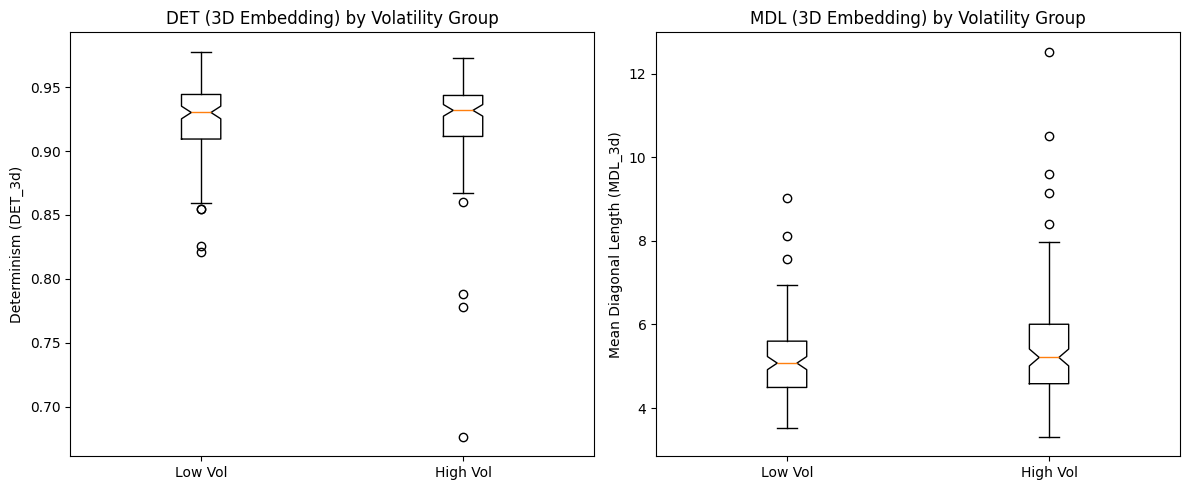

In [5]:
#Load data
df = pd.read_csv('/content/stock_details_5_years.csv', parse_dates=['Date'])
df = df.sort_values(['Company', 'Date'])
df['return'] = df.groupby('Company')['Close'].pct_change()

#Compute volatility & define groups
vol = df.groupby('Company')['return'].std().dropna()
q_low, q_high = vol.quantile([0.25, 0.75])
groups = pd.Series('mid', index=vol.index)
groups[vol <= q_low] = 'low_vol'
groups[vol >= q_high] = 'high_vol'

#RQA helper functions for 3D embedding
def embed(ts, m=3, tau=1):
    N = len(ts) - (m - 1) * tau
    return np.column_stack([ts[i * tau : i * tau + N] for i in range(m)])

def recurrence_plot(X, recurrence_rate=0.05):
    D = squareform(pdist(X, 'euclidean'))
    thresh = np.percentile(D, recurrence_rate * 100)
    return (D <= thresh).astype(int)

def diagonal_stats(R, l_min=2):
    N = R.shape[0]
    runs = []
    for k in range(-N + 1, N):
        d = np.diagonal(R, offset=k)
        lengths = np.diff(np.where(np.concatenate([[0], d, [0]]) != 1)[0]) - 1
        runs.extend(lengths[lengths >= l_min])
    if not runs or R.sum() == 0:
        return 0.0, 0.0
    det = sum(runs) / R.sum()
    return det, np.mean(runs)

#Compute DET_3d & MDL_3d for each company
results_3d = []
for sym, grp in groups.items():
    ts = df[df['Company'] == sym]['Close'].dropna().values
    if len(ts) < 50:
        continue
    ts = (ts - ts.mean()) / ts.std()
    X3 = embed(ts, m=3, tau=1)
    R3 = recurrence_plot(X3, recurrence_rate=0.05)
    det3, mdl3 = diagonal_stats(R3, l_min=2)
    results_3d.append((sym, grp, det3, mdl3))

rqa_3d_df = pd.DataFrame(results_3d, columns=['Company', 'group', 'DET_3d', 'MDL_3d'])

#Prepare data for boxplots
low_3d = rqa_3d_df[rqa_3d_df['group'] == 'low_vol']
high_3d = rqa_3d_df[rqa_3d_df['group'] == 'high_vol']

#Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#Boxplot for DET
axes[0].boxplot([low_3d['DET_3d'], high_3d['DET_3d']], notch=True)
axes[0].set_xticks([1, 2])
axes[0].set_xticklabels(['Low Vol', 'High Vol'])
axes[0].set_ylabel('Determinism (DET_3d)')
axes[0].set_title('DET (3D Embedding) by Volatility Group')

#Boxplot for MDL
axes[1].boxplot([low_3d['MDL_3d'], high_3d['MDL_3d']], notch=True)
axes[1].set_xticks([1, 2])
axes[1].set_xticklabels(['Low Vol', 'High Vol'])
axes[1].set_ylabel('Mean Diagonal Length (MDL_3d)')
axes[1].set_title('MDL (3D Embedding) by Volatility Group')

plt.tight_layout()
plt.show()


# **Visualisation of time delay directions**

In [6]:
#Load data
df = pd.read_csv('/content/stock_details_5_years.csv', parse_dates=['Date'])
df = df.sort_values(['Company', 'Date'])

#Select one stock and normalize
symbol = df['Company'].unique()[0]
ts = df[df['Company'] == symbol]['Close'].dropna().values
ts = (ts - ts.mean()) / ts.std()

#Time‐delay embedding
m, tau = 3, 1
def embed(ts, m, tau):
    N = len(ts) - (m - 1) * tau
    return np.column_stack([ts[i * tau : i * tau + N] for i in range(m)])

embedded = embed(ts, m, tau)

#Subset for visualization
pts = 200
traj = embedded[:pts]

#Compute arrow vectors
u = traj[1:, 0] - traj[:-1, 0]
v = traj[1:, 1] - traj[:-1, 1]
w = traj[1:, 2] - traj[:-1, 2]

#Create interactive 3D scatter with time-index colorbar
scatter = go.Scatter3d(
    x=traj[:, 0], y=traj[:, 1], z=traj[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=np.arange(pts),
        colorscale='Viridis',
        colorbar=dict(title='Time index'),
        showscale=True
    ),
    name='Embedding Points'
)

#Create 3D cone arrows at every step
cones = go.Cone(
    x=traj[:-1, 0], y=traj[:-1, 1], z=traj[:-1, 2],
    u=u, v=v, w=w,
    sizemode='absolute', sizeref=0.2,
    anchor='tail',
    showscale=False,
    colorscale='Viridis',
    name='Direction Vectors'
)

#Build the figure
fig = go.Figure(data=[scatter, cones])
fig.update_layout(
    scene=dict(
        xaxis_title='x(t)',
        yaxis_title=f'x(t + {tau})',
        zaxis_title=f'x(t + {2*tau})',
        aspectmode='auto'
    ),
    title=f'Interactive 3D Embedding with Time Legend<br>{symbol} (m={m}, τ={tau})',
    width=800,
    height=600
)
fig.write_html(
    "Interactive 3D Embedding with time legend.html",
    include_plotlyjs="cdn",
    full_html=True
)
fig.show()

#This gives an intuitive image of what the time delay embedding shows.
#Each 'pin' is the average 'direction' of a small 3 block window in the time series.
#The more often certain directions occor again the more this type of increase/decrease recurs.

# **Recurrence plot for the average closing stock price over the entire time series**

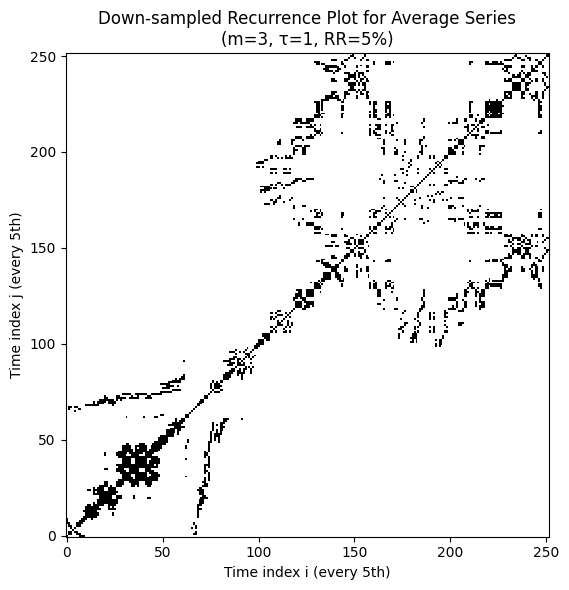

In [7]:
#Load & prepare a single series
df = pd.read_csv('/content/stock_details_5_years.csv', parse_dates=['Date'])
df = df.sort_values('Date')

#Compute the average closing price across all companies at each date
daily_avg = df.groupby('Date')['Close'].mean()
ts = daily_avg.values

#Z-score normalization
ts = (ts - ts.mean()) / ts.std()

#Time-delay embedding
def embed(ts, m=3, tau=1):
    N = len(ts) - (m - 1) * tau
    return np.column_stack([ts[i*tau : i*tau + N] for i in range(m)])

X = embed(ts, m=3, tau=1)

#Build the full recurrence matrix
def recurrence_plot(X, recurrence_rate=0.05):
    D = squareform(pdist(X, 'euclidean'))
    thresh = np.percentile(D, recurrence_rate * 100)
    return (D <= thresh).astype(int)

R_full = recurrence_plot(X, recurrence_rate=0.05)

#Down-sample for plotting
step = 5
R_ds = R_full[::step, ::step]

#Plot the down-sampled recurrence plot
#The average closing stock price data points were downsampled because otherwise the image of the recurrence plot
#would have gotten so many pixels it was not really feasible.
plt.figure(figsize=(6,6))
plt.imshow(R_ds, origin='lower', cmap='Greys', interpolation='none')
plt.xlabel(f'Time index i (every {step}th)')
plt.ylabel(f'Time index j (every {step}th)')
plt.title(f'Down-sampled Recurrence Plot for Average Series\n(m=3, τ=1, RR=5%)')
plt.tight_layout()
plt.show()